In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import gensim.downloader as api
import numpy as np
import re
from tqdm import tqdm

ImportError: cannot import name 'triu' from 'scipy.linalg' (C:\Users\Devin\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\linalg\__init__.py)

In [3]:
# Read the first Excel file
df = pd.read_excel('./Data/combined_dataset_apple_dove_delta_sprint.xlsx') 
# Make all Label = 0 to Label = -1 if not removing the @mentions
# df.loc[df['Label'] == 0, 'Label'] = -1

# Visualize the class distributions
class_counts = df['Label'].value_counts()
class_labels = ['Relevant (1)', 'Not Relevant (-1)', 'Wrong (0)']
# class_labels = ['Not Relevant', 'Relevant']
plt.figure()
plt.bar(class_labels, class_counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()


KeyError: 'Label'

In [3]:
# Write the combined data to CSV if needed
# df.to_csv('combined_data_apple.csv', encoding='utf-8', index=False)

In [4]:
df['Text'] = df['Text'].fillna('').astype(str)

def append_keyword(row):
    # keyword = row['keyword'] + ": "
    keyword = "1: "
    text = row['Text']
    return keyword + text

df["Text"] = df.apply(append_keyword, axis=1)


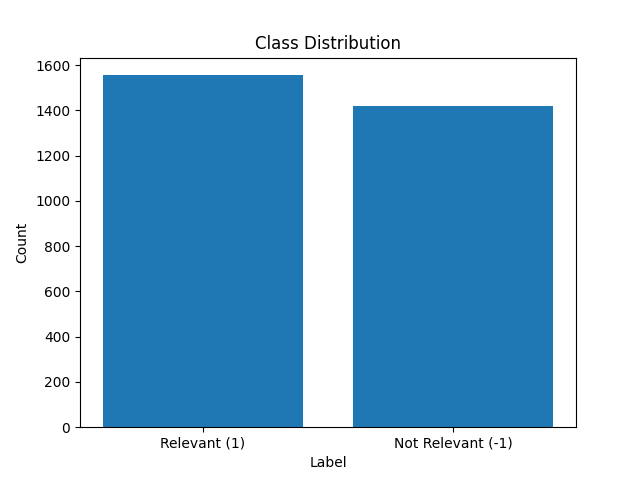

In [5]:
df['Text'] = df['Text'].fillna('').astype(str)
# df['keyword'] = df['keyword'].fillna('').astype(str)

# Step 2: Define a function to check keyword occurrences
def check_keyword_occurrences(row):
    # keyword = row['keyword']
    keyword = 'apple'
    text = row['Text']
    # Create a regex pattern to find isolated occurrences of the keyword
    pattern = fr'\b{keyword}\b'  # '\b' is a word boundary in regex
    
    # Find all occurrences of the keyword
    all_occurrences = re.findall(pattern, text, flags=re.IGNORECASE)
    
    # Find all occurrences that are part of other strings like @mentions
    mention_occurrences = re.findall(fr'@\w*{keyword}\w*', text, flags=re.IGNORECASE)
    
    # Check if there are no isolated occurrences of the keyword
    # and at least one mention-like occurrence
    if len(all_occurrences) == 0 and len(mention_occurrences) > 0:
        return False  # Remove this row because keyword only appears in mentions
    return True  # Keep this row because keyword appears isolated or not in mentions at all


# Step 3: Filter the DataFrame
filtered_df = df[df.apply(check_keyword_occurrences, axis=1)]

# Step 4: Save the processed DataFrame
# filtered_df.to_csv('processed_file_apple.csv', index=False)

# Make 0s as -1
filtered_df.loc[filtered_df['Label'] == 0, 'Label'] = -1

class_counts = filtered_df['Label'].value_counts()
class_labels = ['Relevant (1)', 'Not Relevant (-1)']
# class_labels = ['Not Relevant', 'Relevant']
plt.figure()
plt.bar(class_labels, class_counts)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

In [6]:
# Comment this to run without @mention filtering.
df = filtered_df
# Load pre-trained word embeddings (word2vec)
word_vectors = api.load("word2vec-google-news-300")

In [7]:
# Feature extraction and SVC


def extract_features(text):
    if isinstance(text, str):
        tokens = text.lower().split()  # Tokenize and convert to lowercase
        word_embeddings = [word_vectors[token] for token in tokens if token in word_vectors]  # Get word embeddings
        return sum(word_embeddings) if word_embeddings else None  # Sum of word embeddings
    else:
        return None  # Return None for non-string inputs

df['Features'] = df['Text'].apply(extract_features)

# Remove rows with missing features
df = df.dropna()
df.loc[df['Label'] == 0, 'Label'] = -1

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['Features'].tolist(), df['Label'], test_size=0.2)#, random_state=42)

# Train a Support Vector Classifier (SVC)
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          -1       0.85      0.81      0.83       288
           1       0.83      0.86      0.85       307

    accuracy                           0.84       595
   macro avg       0.84      0.84      0.84       595
weighted avg       0.84      0.84      0.84       595



# Attempt at combined classification

In [8]:
def extract_balanced_sample(df, num_samples=500):
    positive_samples = df[df['Label'] == 1]
    negative_samples = df[df['Label'] == -1]

    positive_samples = positive_samples.sample(min(len(positive_samples), num_samples//2), random_state=42)
    negative_samples = negative_samples.sample(min(len(negative_samples), num_samples//2), random_state=42)

    # Concatenate the sampled positive and negative samples
    balanced_df = pd.concat([positive_samples, negative_samples])

    # Shuffle the DataFrame
    balanced_df = balanced_df.sample(frac=1)#, random_state=42)
    return balanced_df


In [9]:
df = pd.read_excel('./Data/combined_dataset_apple_dove_delta_sprint.xlsx')

# Comment this if you don't want to balance class data
# df4 = extract_balanced_sample(df4, num_samples=500)

df['Text'] = df['Text'].fillna('').astype(str)
df = df[df.apply(check_keyword_occurrences, axis=1)]

# List of compaanies you want to perform classification on
entities = ['apple', 'dove', 'sprint', 'spirit', 'delta']

# Select only the rows with the specified companies in the 'Keyword' column
df = df[df['Keyword'].isin(entities)]
df = df[df['Label'] != 0]
df

,Keyword,Label,Text
0,apple,1,They really have delayed it? http://www.apple....
1,apple,-1,mmmm...apples and organic peanut butter.
3,apple,1,Apple folks â waste of my to log copious Rad...
4,apple,1,@Skroob Hey now! That second one is a bit racy...
5,apple,-1,applebees best place for rainy days
...,...,...,...
3572,sprint,1,@ajgrubb I'm stuck with Sprint for another year.
3573,sprint,1,Just tryed out the palm pre at the sprint stor...
3574,sprint,1,@PreThinking Awww I thought that was going to ...
3575,sprint,1,Annndd.. Sprint really sucks down there! What ...


In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import gensim.downloader as api

# Load pre-trained word embeddings (word2vec)
# word_vectors = api.load("word2vec-google-news-300")

In [11]:
# Feature extraction with keyword embeddings
def extract_features(row):
    """This function uses both keyword and text to create an embedding
        vector for each row in the dataframe."""
    # Extract keyword and text
    keyword = row['Keyword']
    text = row['Text']

    # Embeddings for keyword
    keyword_embedding = word_vectors[keyword] if keyword in word_vectors else np.zeros(300)

    # Embeddings for text
    tokens = text.lower().split()
    text_embeddings = [word_vectors[token] for token in tokens if token in word_vectors]
    text_embedding_sum = sum(text_embeddings) if text_embeddings else np.zeros(300) 

    # Combine embeddings by averaging or summing
    combined_embedding = (keyword_embedding + text_embedding_sum) / (len(text_embeddings) + 3 if text_embeddings else 1)

    return combined_embedding

# Without keyword embeddings
# def extract_features(row):
#     text = row['Text']

#     # Embeddings for text
#     tokens = text.lower().split()
#     text_embeddings = [word_vectors[token] for token in tokens if token in word_vectors]
#     text_embedding_sum = sum(text_embeddings) if text_embeddings else np.zeros(300) 
#     return text_embedding_sum

# Ensure string type and handle missing data
df['Keyword'] = df['Keyword'].fillna('').astype(str)
df['Text'] = df['Text'].fillna('').astype(str)
df.loc[df['Label'] == 0, 'Label'] = -1

# Apply feature extraction
df['Features'] = df.apply(extract_features, axis=1)

# Remove rows with missing features if any (none should be missing with the current setup)
df = df.dropna(subset=['Features'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(df['Features'].tolist(), df['Label'], test_size=0.2)#, random_state=42)

# Train classifier
clf = SVC(kernel='linear')
clf.fit(list(X_train), y_train)

# Predictions
y_pred = clf.predict(list(X_test))

# Evaluation
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

          -1       0.89      0.82      0.86       277
           1       0.85      0.91      0.88       311

    accuracy                           0.87       588
   macro avg       0.87      0.87      0.87       588
weighted avg       0.87      0.87      0.87       588



In [12]:
for index, row in tqdm(df.iterrows()):
    features = np.asarray(row["Features"]).reshape(1,-1)
    SVC_pred = clf.predict(features)
    df.at[index, 'SVC_pred'] = SVC_pred
    

2937it [00:02, 986.87it/s] 


In [13]:
curr_results = df
curr_results.to_csv('Data/Results_pred_combined.csv', index=False)
df.head()

,Keyword,Label,Text,Features,SVC_pred
0,apple,1,They really have delayed it? http://www.apple....,"[-0.01750837, 0.010341099, 0.007271903, 0.0755...",1.0
1,apple,-1,mmmm...apples and organic peanut butter.,"[-0.029125977, -0.031591795, 0.043286134, 0.17...",-1.0
3,apple,1,Apple folks â waste of my to log copious Rad...,"[0.036539715, 0.022143893, 0.016567655, 0.0955...",1.0
4,apple,1,@Skroob Hey now! That second one is a bit racy...,"[0.051071167, -0.04460449, 0.05045166, 0.09698...",-1.0
5,apple,-1,applebees best place for rainy days,"[-0.04297638, 0.07739258, 0.040992737, 0.02030...",-1.0


# Trying to visualize

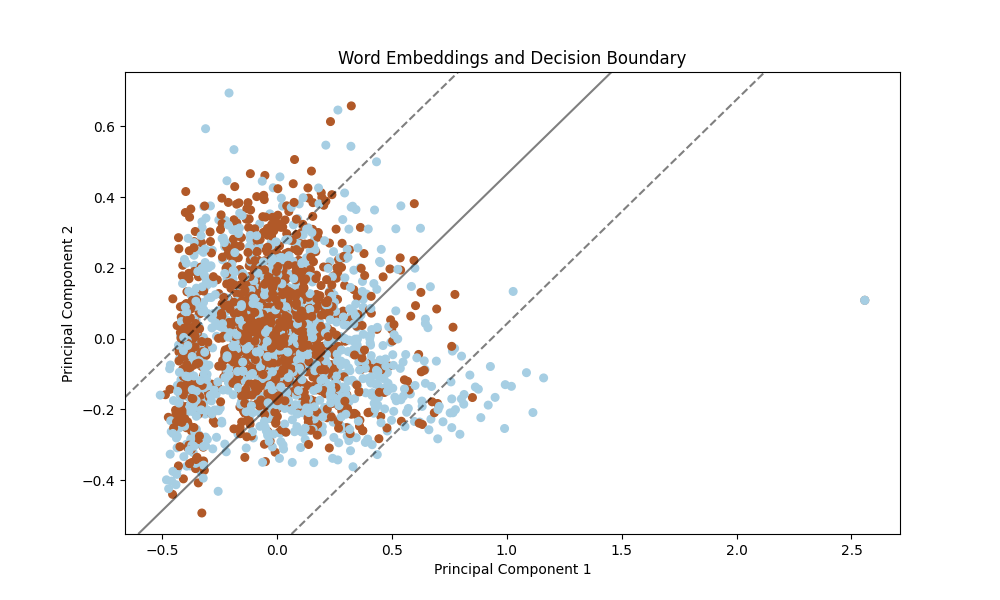

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# Assuming word_vectors, X_train, y_train are defined as in the previous code snippet

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)

# Train a Support Vector Classifier (SVC) with linear kernel
clf = SVC(kernel='linear')
clf.fit(X_train_pca, y_train)

# Visualize word embeddings and decision boundaries
def plot_embedding_and_decision_boundary(X, y, clf, pca):
    # Plot word embeddings
    plt.figure(figsize=(10, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired, s=30)

    # Plot decision boundary
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # Create grid to evaluate model
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                         np.linspace(ylim[0], ylim[1], 50))
    Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])

    # Plot decision boundary and margins
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
                linestyles=['--', '-', '--'])

    plt.title('Word Embeddings and Decision Boundary')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

plot_embedding_and_decision_boundary(X_train_pca, y_train, clf, pca)


# LLM test

### The next block of code is just a repeat of reading the data files. 
- Need to figure out a way to just use test data.


In [30]:
# Uncomment this only if you running LLM inference alone.
# If running LLM only, DO NOT SAVE THE INTERMEDIATE FILE
df = pd.read_csv("./dataCSV.csv")

# List of compaanies you want to perform classification on
entities = ['apple', 'dove', 'sprint', 'spirit', 'delta']

# Select only the rows with the specified companies in the 'Keyword' column
df = df[df['Keyword'].isin(entities)]
df = df[df['True_label'] != 0]

In [51]:
df["Keyword"].unique()

array(['apple', 'delta', 'dove', 'sprint'], dtype=object)

In [75]:
openai.api_key = "none"
model_id = 'gpt-4-turbo'

def get_model_response(text, keyword):

    relevance = ""
    relevance_apple = "Apple, Inc. (the technology company)"
    relevance_dove = "Dove (the toiletries/personal care brand owned by Unilever)"
    relevance_delta = "Delta Air Lines (the Atlanta-based airline)"
    relevance_sprint = "Sprint (the telecommunications/phone service company)"
    
    if keyword == "apple":
        relevance = relevance_apple
    elif keyword == "dove":
        relevance = relevance_dove
    elif keyword == "delta":
        relevance = relevance_delta
    elif keyword == "sprint":
        relevance = relevance_sprint

    prompt = f"""At the end of this prompt, in single-quotes, is a tweet containing the substring "{keyword}".
            It needs to be classified into one of the two classes. The classes are:
            1: The test string IS PERTINENT IN ANY WAY to {relevance}.
            -1: The test string IS NOT PERTINENT IN ANY WAY to {relevance}.
            If there is insufficient context, intelligently (using sentiment and the existing context) pick what you think is the most likely class.
            In your response, you must output a single token, -1 or 1, with the correct class.
            Test string below:
            
            '{text}'"""

    response = openai.ChatCompletion.create(
        model=model_id,
        messages=[{'role': 'user', 'content': prompt}]
    )
    output = response.choices[0].message.content

    try:
        output_int = int(output)
        conversion_error = None
    except ValueError:
        output_int = 0
        conversion_error = f"Conversion error for Keyword: {keyword}, Text: {text}"
 
    return output_int, conversion_error

In [77]:
# Iterate through each row of the DataFrame and call the function
error_count = 0
conversion_errors = []
count = 0 # Set counter to skip n rows if restarting due to rate limits
skip_t = 320

for index, row in df.iterrows():
    # Set counter to skip n rows if restarting due to rate limits
    if count < skip_t:
        count += 1
        continue
        
    count+=1
    
    try:
        # save every 10th row to intermediate file in case you run into rate limit errors.
        if count % 10 == 0:
            print(f"At iteration #{index}")
            print(f"Last input text: {text}")
            print(f"Last model label: {output_int}")
            df.to_csv('Data/LLM_result_intermediate.csv', index=False)

        keyword = row['Keyword']
        text = row['Text']
        label = row['True_label']
        
        # Call the function with Keyword, Text, and Label as inputs
        output_int, conversion_error = get_model_response(text, keyword)

        
        # Handle conversion errors
        if conversion_error:
            conversion_errors.append(conversion_error)
            error_count += 1

        df.at[index, 'LLM_pred'] = output_int
    except Exception as e:
        print(e)
        break

# Print conversion errors
if conversion_errors:
    print("Conversion errors:")
    for error in conversion_errors:
        print(error)


At iteration #329
Last input text: Best load of muffins so far  Appleby Cheese &amp; Chive scones next on baking list, together with chicken Biryani for tea today.
Last model label: -1
At iteration #339
Last input text: I managed to forget my sandwich today and only have 40p. Lunch will be a packet of crisps and an apple 
Last model label: -1
At iteration #349
Last input text: Hmm, Apple Store out of 32gig  Should be back in tomorrow. Wonder if I should book a personal shopping appointment with @eightlab ?
Last model label: 1
At iteration #359
Last input text: @clielasus - yes way! It died at first startup and was just beeping so it needs to go back to Apple, have to wait for a replacement now 
Last model label: 1
At iteration #369
Last input text: @thecoleorton my 3GS has got to go back to Apple 
Last model label: 1
At iteration #379
Last input text: Not feeling too well. I think I ate too much of that apple and date nut cake we baked yesterday. And Im not even feeling thin anymore. 


In [78]:
df

,Keyword,True_label,SVC_label,SVC_diff,Text,SVC_Features,LLM_pred
0,apple,-1,1,-2,@zoopedup Apple Mail. Integrates seemlessly wi...,[ 0.21679688 -0.40039062 -0.08532715 0.902099...,1.0
1,apple,-1,1,-2,"@TheFilmo Haha nopers, I'm a Snapple Fact frea...",[ 0.07601929 0.36657715 0.10336304 1.133178...,-1.0
2,apple,-1,1,-2,@omshivaprakash weatherunderground.com nali da...,[ 0.20178223 0.1574707 -0.48657227 0.740722...,-1.0
3,apple,-1,1,-2,I really wanted a slice of our apple pie. Made...,[ 2.2360229e-01 3.0737305e-01 5.2941895e-01 ...,-1.0
4,apple,-1,1,-2,OD'd on apple juice... that's not code for any...,[ 7.77648926e-01 -5.46770096e-01 1.62094116e+...,-1.0
...,...,...,...,...,...,...,...
737,delta,1,-1,2,@leesemp and I trying to make it home from a w...,[ 0.39453125 0.939414 0.375 0.666564...,-1.0
738,sprint,1,-1,2,@CashVerde but I have the latest curve from sp...,[ 1.85546875e-02 5.24483681e-01 2.99072266e-...,1.0
739,sprint,1,-1,2,@SoCalMario sounds pretty sweet but it's only...,[ 0.43530273 -0.17382812 -0.14086914 1.134338...,1.0
740,sprint,1,-1,2,Im bout to get that Sprint Palm Pre this morni...,[-8.81347656e-02 7.22045898e-02 -5.41015625e-...,1.0


In [80]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score


In [82]:

# Calculate metrics
accuracy = accuracy_score(df['True_label'], df['LLM_pred'])
precision = precision_score(df['True_label'], df['LLM_pred'])
recall = recall_score(df['True_label'], df['LLM_pred'])
f1 = f1_score(df['True_label'], df['LLM_pred'])

# To calculate the False Positive Rate (FPR), we need the confusion matrix
tn, fp, fn, tp = confusion_matrix(df['True_label'], df['LLM_pred']).ravel()
false_positive_rate = fp / (fp + tn)

# Print results
print("Accuracy:", accuracy)
print("False Positive Rate:", false_positive_rate)
print("Precision:", precision)
print("Recall/True Positive Rate:", recall)
print("F1 Score:", f1)

# When the model predicts a positive result, it is very likely to be correct. 
# However, the lower recall indicates that the model is missing a decent proportion of the actual positive cases.

Accuracy: 0.9204851752021563
False Positive Rate: 0.01891891891891892
Precision: 0.9785932721712538
Recall/True Positive Rate: 0.8602150537634409
F1 Score: 0.9155937052932761


In [43]:
df.drop(["SVC_label", "SVC_diff", "SVC_Features"], axis=1)

,Keyword,True_label,Text,LLM_pred
0,apple,-1,@zoopedup Apple Mail. Integrates seemlessly wi...,1.0
1,apple,-1,"@TheFilmo Haha nopers, I'm a Snapple Fact frea...",-1.0
2,apple,-1,@omshivaprakash weatherunderground.com nali da...,-1.0
3,apple,-1,I really wanted a slice of our apple pie. Made...,-1.0
4,apple,-1,OD'd on apple juice... that's not code for any...,-1.0
...,...,...,...,...
737,delta,1,@leesemp and I trying to make it home from a w...,-1.0
738,sprint,1,@CashVerde but I have the latest curve from sp...,-1.0
739,sprint,1,@SoCalMario sounds pretty sweet but it's only...,-1.0
740,sprint,1,Im bout to get that Sprint Palm Pre this morni...,-1.0


In [45]:
df.iloc[741].Text

'@Digital_Girl ...My phone = BROKEN PIECE OF ISH SPRINT  I REALLY need a new one!!! Stopped turning on :/'

In [18]:
# Filter out the df where the LLM_pred is not null
# so that we can have clean data if program is interrupted due to errors


curr_results = df[df['LLM_pred'].notna()]

# Make a new column where it is 1 if SVC_pred and LLM_pred are not equal
curr_results['Diff'] = np.where(curr_results['Label'] == curr_results['LLM_pred'], 0, 1)
curr_results.to_csv('Data/Results_pred_combined.csv', index=False)
curr_results.head()

KeyError: 'LLM_pred'